In [158]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split as tts
import torch.nn as nn
from tqdm import tqdm

In [193]:
def load_data(file_path):
    """
    Takes the path to where the .npy file is located.

    :param file_path: The path with the path to the folder where the
    data is saved.
    :return: data, labels

    Example using savedata/loaddata:
    path = "test"
    save_data(path, data, labels) # saves data as .npy file
    data, labels = load_data(path) # loads .npy file
    """
    if file_path[-4:] != '.npy':
        file_path += '.npy'

    with open(file_path, 'rb') as f:
        data = np.load(f)
        label = np.load(f)

    return data, label


class NumbersDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = torch.from_numpy(samples).to(torch.float32)
        self.labels = torch.from_numpy(labels).to(torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


class Network(nn.Module):
    def __init__(self, hidden_layer_dims: list[int], input_size: int, device: torch.device) -> None:
        super(Network, self).__init__()
        self.device = device
        
        self.relu = nn.ReLU().to(device)
        self.l1 = nn.Linear(input_size, hidden_layer_dims[0]).to(device)
        self.ln = nn.Linear(hidden_layer_dims[-1], 2).to(device)
        self.ls = [self.l1]
        
        for i in range(len(hidden_layer_dims) - 1):
            self.ls.append(
                nn.Linear(hidden_layer_dims[i], hidden_layer_dims[i+1]).to(device)
            )
        self.ls.append(self.ln)
        
    def forward(self, x: np.array) -> np.array:
        out = self.relu(self.ls[0](x))
        for l in self.ls[1:-1]:
            out = self.relu(l(out))
        out = self.ls[-1](out)
        
        return out

In [194]:
data, labels = load_data('data_(50000_1000_2)/nonlin_data.npy')

In [195]:
batch_size = 100
epochs = 20
learning_rate = 0.00001
hidden_layers = [500, 500, 500]

In [196]:
data_trn_np, data_tst_np, label_trn_np, label_tst_np = tts(data, labels, test_size=0.1)

label_train_reshaped = np.zeros((len(label_trn_np), 2))
label_test_reshaped = np.zeros((len(label_tst_np), 2))

for i, trn in enumerate(label_trn_np):
    label_train_reshaped[i, int(trn)] = 1

for i, tst in enumerate(label_tst_np):
    label_test_reshaped[i, int(tst)] = 1

data_train = NumbersDataset(data_trn_np, label_train_reshaped)
data_test = NumbersDataset(data_tst_np, label_test_reshaped)

loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
loader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True, pin_memory=True)

input_size = int(data_trn_np.shape[1]*data_trn_np.shape[2])


In [197]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [198]:
model = Network(
    hidden_layer_dims=hidden_layers,
    input_size=input_size,
    device=device
).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [199]:
# Train the data
num_steps = len(loader_train)
loss_list = []
loss_avg_trn = []
loss_avg_tst = []
for epoch in tqdm(range(epochs)):
    for i, (value, label) in enumerate(loader_train):
        sample = value.reshape(batch_size, -1).to(device)
        label = label.view(label.shape[0], 2).to(device)
        
        # forward
        output = model(sample)
        loss = criterion(output, label)
        loss_list.append(loss.item())
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    with torch.no_grad():
        loss_test = []
        for value, label in loader_test:
            sample = value.reshape(batch_size, -1).to(device)
            label = label.view(label.shape[0], 2).to(device)
            
            output = model(sample)
            loss = criterion(output, label)
            
            loss_test.append(loss.item())
    
    loss_avg_trn.append(np.mean(np.array(loss_list)))
    loss_avg_tst.append(np.mean(np.array(loss_test)))
    
    loss_list = []
    loss_test = []
    

100%|██████████| 20/20 [00:55<00:00,  2.75s/it]


In [200]:
with torch.no_grad():
    out_list = []
    label_list = []

    labs1d = []
    pred1d = []
    n_samples = 0
    n_diff = 0
    
    for value, label in loader_test:
        sample = value.reshape(batch_size, -1).to(device)
        label = label.view(label.shape[0], 2).to(device)
        label_list += label.tolist()
        
        output = model(sample)
        out_list += output.tolist()
        _, pred = torch.max(output, 1)
        _, labs = torch.max(label, 1)
        n_diff += torch.abs(pred-labs)

        pred1d += pred.tolist()
        labs1d += labs.tolist()

        n_samples += 1
    
    #acc = n_diff/n_samples
pred1d = np.array(pred1d)
labs1d = np.array(labs1d)

In [201]:
acc = np.count_nonzero(pred1d == labs1d)/len(labs1d)
acc0 = (len(pred1d[np.where(labs1d==0)])-np.sum(pred1d[np.where(labs1d==0)]))/len(np.where(labs1d==0)[0])
acc1 = np.sum(pred1d[np.where(labs1d==1)])/len(np.where(labs1d==1)[0])

print(f"{acc*100:.5f}% overall accuracy")
print(f"{acc0*100:.5f}% of 0 guessed correctly")
print(f"{acc1*100:.5f}% of 1 guessed correctly")

89.14000% overall accuracy
89.48000% of 0 guessed correctly
88.80000% of 1 guessed correctly


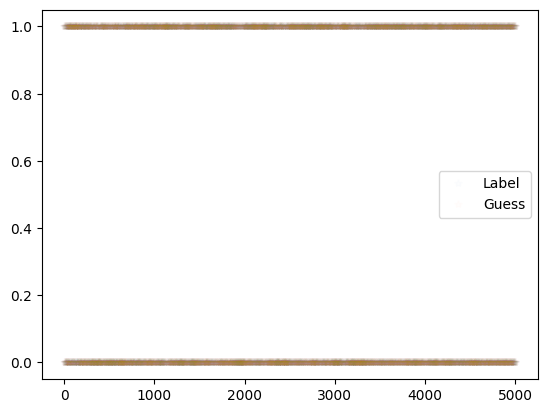

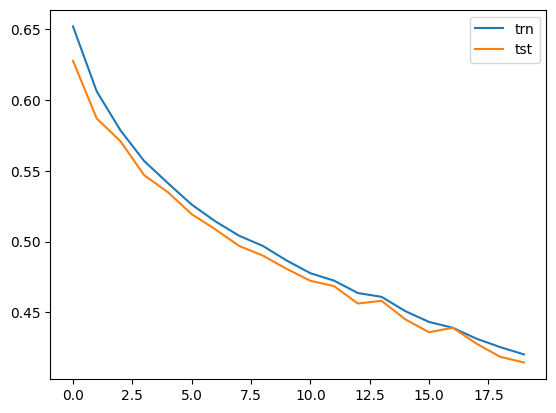

In [202]:
plt.plot(labs1d, '*', label='Label', alpha=0.01)
plt.plot(pred1d, '*', label='Guess', alpha=0.01)
plt.legend()
plt.show()

plt.plot(np.array(loss_avg_trn), label="trn")
plt.plot(np.array(loss_avg_tst), label="tst")
plt.legend()
plt.show()